# Optimal Classification Tree

This notebook document is a **python** implementation for two new methods of Optimal Classification Trees proposed by Enhao Liu and Theodore Allen: (1) Modified-Optimal Classification Tree (M-OCT) and (2) BinaryNodePenalty-Optimal Classification Tree (BNP-OCT)

Contact: Enhao Liu (liu.5045@osu.edu), Theodre Allen (allen.515@osu.edu)

# Library Settings

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

from lsoct.tree import OptimalTreeClassifier ## M-OCT propsed by Liu & Allen
from lsoct.tree import BinNodePenaltyOptimalTreeClassifier ## BNP-OCT propsed by Liu & Allen
# from lsoct.tree import OldOptimalTreeClassifier ## OCT proposed by Bertsimas & Dunn

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import tree 

import graphviz

%load_ext autoreload
%autoreload 2

# Optimal Classification Tree

## Example: Iris Dataset

In [2]:
data_path = './data/Iris.csv'

iris_data = pd.read_csv(data_path)
iris_data.drop(columns=["Id"], inplace=True)

In [10]:
iris_data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
X = iris_data.iloc[:, 0:4].to_numpy()
y = iris_data["Species"].to_numpy()

### M-OCT

The M-OCT is a modified version of the original OCT formulation (Bertsimas & Dunn, 2017). In the M-OCT formulation, we consider new leaf-branch-interaction constraints to ensure valid tree structure when learning the optimal trees.

In [4]:
from lsopt.tree import OptimalTreeClassifier ## M-OCT propsed by Liu & Allen
from lsopt.tree import BinNodePenaltyOptimalTreeClassifier ## BNP-OCT propsed by Liu & Allen

# OCT parameters
max_depth = 3
min_samples_leaf = 1
alpha = 0.01
time_limit = 5  # minute
mip_gap_tol = 0.5  # optimal gap percentage
mip_focus = 'balance'
mip_polish_time = None
warm_start = False
log_file = None

# Construct OCT classifier
oct_model = OptimalTreeClassifier(max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  alpha=alpha,
                                  criterion="gini",
                                  solver="gurobi",
                                  time_limit=time_limit,
                                  verbose=True,
                                  warm_start=warm_start,
                                  log_file=log_file,
                                  solver_options={'mip_cuts': 'auto',
                                                  'mip_gap_tol': mip_gap_tol,
                                                  'mip_focus': mip_focus,
                                                  'mip_polish_time': mip_polish_time
                                                  }
                                  )

In [5]:
# Fit
oct_model.fit(X, y)

Using license file /Users/enhaoliu/gurobi.lic
Academic license - for non-commercial use only
Read LP format model from file /var/folders/5y/drctn5r14mzfjfjnld2ybpc80000gn/T/tmpz_mdbe0o.pyomo.lp
Reading time = 0.03 seconds
x1315: 5081 rows, 1312 columns, 28848 nonzeros
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Parameter Cuts unchanged
   Value: -1  Min: -1  Max: 3  Default: -1
Changed value of parameter MIPGap to 0.5
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Parameter MIPFocus unchanged
   Value: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 5081 rows, 1312 columns and 28848 nonzeros
Model fingerprint: 0x63cb3227
Variable types: 48 continuous, 1264 integer (1264 binary)
Coefficient statistics:
  Matrix range     [1e-06, 2e+02]
  Objective range  [1e-02, 1e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 316 rows and 5 columns

In [6]:
# Make prediction
y_pred = oct_model.predict(X=X)
y_pred_prob = oct_model.predict_proba(X=X)

# Check confusion matrix
print("Confusion Matrix :")
print(confusion_matrix(y_true=y,
                       y_pred=y_pred))

print(classification_report(y_true=y,
                            y_pred=y_pred))

# Plot Optimal Tree
feature_names = iris_data.columns.values[:4]
class_names = np.unique(y)

dot_data = tree.export_graphviz(oct_model,
                                out_file=None,
                                feature_names=feature_names,
                                class_names=class_names,
                                label='all',
                                impurity=True,
                                node_ids=True,
                                filled=True,
                                rounded=True,
                                leaves_parallel=True,
                                special_characters=False)

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render(filename='optimal_tree_iris', directory='', view=True)

Confusion Matrix :
[[50  0  0]
 [ 0 47  3]
 [ 0  0 50]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       1.00      0.94      0.97        50
 Iris-virginica       0.94      1.00      0.97        50

       accuracy                           0.98       150
      macro avg       0.98      0.98      0.98       150
   weighted avg       0.98      0.98      0.98       150



'optimal_tree_iris.png'

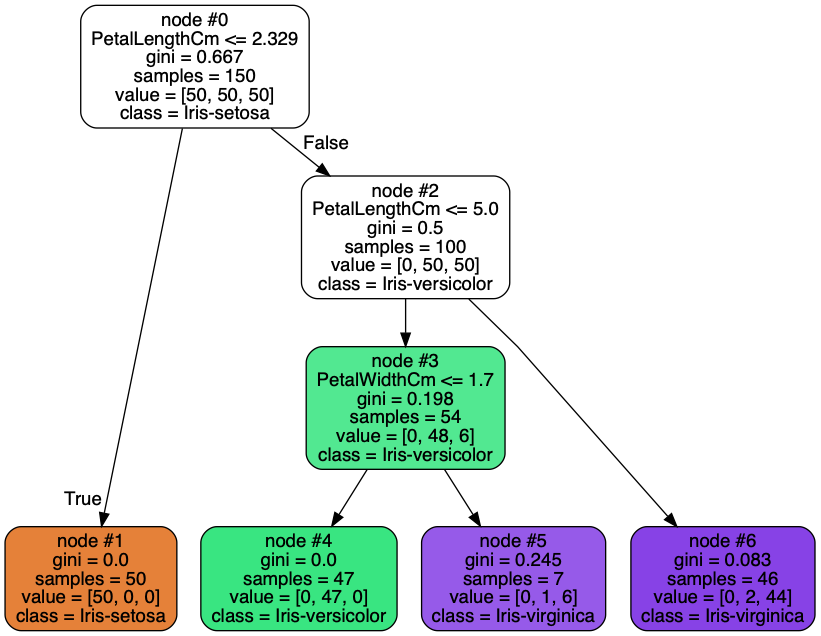

In [7]:
Image('optimal_tree_iris.png')

### Greedy : CART

In [8]:
## Fit CART
cart_model = tree.DecisionTreeClassifier(max_depth=3, criterion="gini")
cart_model.fit(X, y)


## Make prediction
y_pred = cart_model.predict(X)
y_pred_prob = cart_model.predict_proba(X=X)

# Check confusion matrix
print("Confusion Matrix :")
print(confusion_matrix(y_true=y,
                       y_pred=y_pred))

print(classification_report(y_true=y,
                            y_pred=y_pred))

# Plot Greedy Tree
feature_names = iris_data.columns.values[:4]
class_names = np.unique(y)

dot_data = tree.export_graphviz(cart_model,
                                out_file=None,
                                feature_names=feature_names,
                                class_names=class_names,
                                label='all',
                                impurity=True,
                                node_ids=True,
                                filled=True,
                                rounded=True,
                                leaves_parallel=True,
                                special_characters=False)

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render(filename='greedy_tree_iris', directory='', view=True)


Confusion Matrix :
[[50  0  0]
 [ 0 47  3]
 [ 0  1 49]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       0.98      0.94      0.96        50
 Iris-virginica       0.94      0.98      0.96        50

       accuracy                           0.97       150
      macro avg       0.97      0.97      0.97       150
   weighted avg       0.97      0.97      0.97       150



'greedy_tree_iris.png'

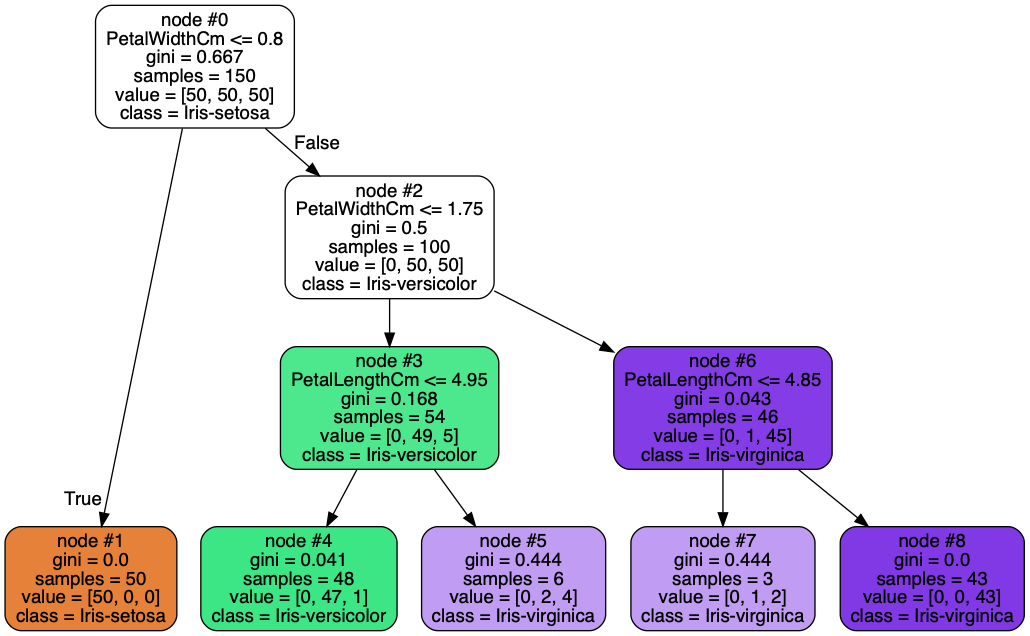

In [9]:
Image('greedy_tree_iris.png')